In [1]:
import cfRestApiV3 as cfApi
import datetime
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
# accessible on your Account page under Settings -> API Keys
apiPublicKey = "X0J+mG76qUHLfr7G4Yk0/cSX7+T7cApznHo2opaEOOqNZKed2AmDFuMI"
# accessible on your Account page under Settings -> API Keys
apiPrivateKey = "YMyZG6GhXNmvW/ZvLzFp5zxTX+dmfPJCp8Vzamz8LJ+CBmQmloF7yBC3/sD3mNrMw8i8CtNqMnd9233v3+6kpUlT"

In [3]:
# use "api.cryptofacilities.com" if your IP is whitelisted (Settings -> API Keys -> IP Whitelist)
apiPath = "https://www.cryptofacilities.com"
timeout = 20
checkCertificate = True  # when using the test environment, this must be set to "False"
useNonce = False  # nonce is optional

cfPublic = cfApi.cfApiMethods(
    apiPath, timeout=timeout, checkCertificate=checkCertificate)
cfPrivate = cfApi.cfApiMethods(apiPath, timeout=timeout, apiPublicKey=apiPublicKey,
                               apiPrivateKey=apiPrivateKey, checkCertificate=checkCertificate, useNonce=useNonce)

In [4]:
# # get instruments
# result = cfPublic.get_instruments()
# print("get_instruments:\n", result)

In [5]:
# # get tickers
# result = cfPublic.get_tickers()
# print("get_tickers:\n", result)

In [6]:
# # get order book
# symbol = "PI_XBTUSD"
# result = cfPublic.get_orderbook(symbol)
# print("get_orderbook:\n", result)

In [7]:
# # get history
# symbol = "PI_XBTUSD"  # "PI_XBTUSD", "cf-bpi", "cf-hbpi"
# lastTime = datetime.datetime.strptime(
#     "2024-11-29", "%Y-%m-%d").isoformat() + ".000Z"
# result = cfPublic.get_history(symbol, lastTime=lastTime)
# print("get_history:\n", result)

In [8]:
# # get prices
# result = cfPublic.get_market_price(symbol)
# print("get_market_price:\n", "%s elements" % len(result))

# Daily comparison last day

In [9]:
MA="250328"
QA="250627"

In [10]:
days_to_MA = (datetime.datetime.strptime(MA, "%y%m%d") - datetime.datetime.today()).days
days_to_QA = (datetime.datetime.strptime(QA, "%y%m%d") - datetime.datetime.today()).days

## BTC

In [11]:
symbol1 = "PI_XBTUSD"
symbol2 = "FF_XBTUSD_"+MA
symbol3 = "FF_XBTUSD_"+QA

In [12]:
# Current time
now = datetime.datetime.utcnow()

# Generate times for the last 24 hours
last_24_hours = [
    (now - datetime.timedelta(hours=i)).replace(minute=0, second=0, microsecond=0).isoformat() + ".000Z"
    for i in range(100)
]

# Generate timestamps for the last 24 hours in 10-minute intervals
last_24_hours_10min = [
    ( datetime.datetime.utcnow() -  datetime.timedelta(minutes=10 * i)).replace(second=0, microsecond=0).isoformat() + ".000Z"
    for i in range(130)  # 24 hours * 6 intervals per hour = 144 intervals
]

# Display the generated timestamps
last_24_hours_10min[:10]  # Show first 10 timestamps as a sample

['2025-02-10T08:03:00.000Z',
 '2025-02-10T07:53:00.000Z',
 '2025-02-10T07:43:00.000Z',
 '2025-02-10T07:33:00.000Z',
 '2025-02-10T07:23:00.000Z',
 '2025-02-10T07:13:00.000Z',
 '2025-02-10T07:03:00.000Z',
 '2025-02-10T06:53:00.000Z',
 '2025-02-10T06:43:00.000Z',
 '2025-02-10T06:33:00.000Z']

In [13]:
times=last_24_hours_10min

In [14]:
result=[]
for t in times:
    try:
        price1=json.loads(cfPublic.get_history(symbol1, lastTime=t))['history'][-1]['price']
        price2=json.loads(cfPublic.get_history(symbol2, lastTime=t))['history'][-1]['price']
        price3=json.loads(cfPublic.get_history(symbol3, lastTime=t))['history'][-1]['price']
        result.append((t, price1, price2, price3))
    except:
        pass

In [15]:
df=pd.DataFrame(result, columns=['datetime', 'SPOT', 'MAR-25', 'JUN-25'])

In [16]:
df

,datetime,SPOT,MAR-25,JUN-25
0,2025-02-10T08:03:00.000Z,97431.0,98505,100903
1,2025-02-10T07:53:00.000Z,97393.5,98400,100658
2,2025-02-10T07:43:00.000Z,97284.5,98400,100655
3,2025-02-10T07:33:00.000Z,97146.5,98300,100358
4,2025-02-10T07:23:00.000Z,97139.5,98300,100358
...,...,...,...,...
125,2025-02-09T11:13:00.000Z,96872.0,97975,100005
126,2025-02-09T11:03:00.000Z,96856.0,97975,100005
127,2025-02-09T10:53:00.000Z,96734.0,97900,100005
128,2025-02-09T10:43:00.000Z,96734.0,97900,100005


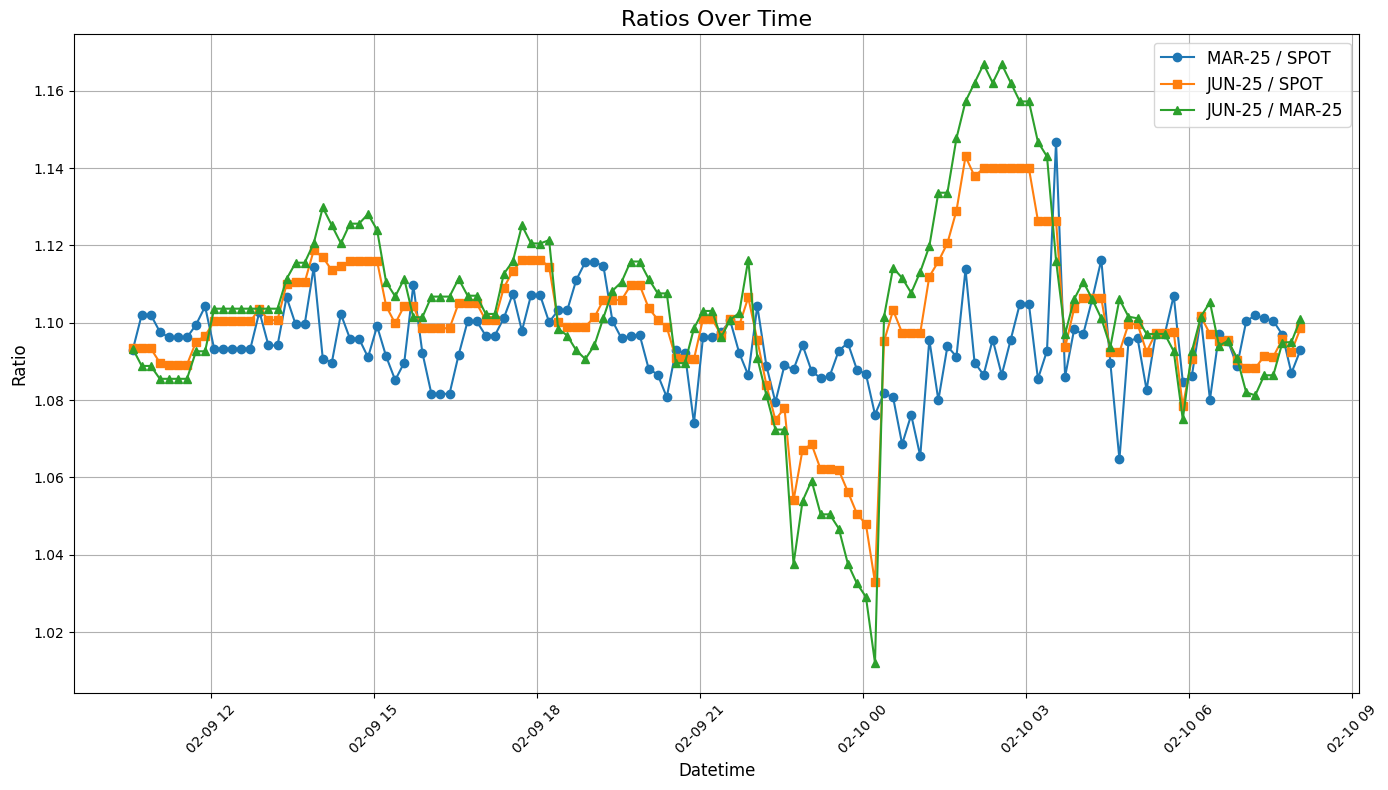

In [17]:
# Convert 'datetime' to pandas datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Calculate ratios
df['Ratio_1'] = (df['MAR-25'] / df['SPOT']) ** (365/days_to_MA)  # (3rd to 2nd) to the power of 12
df['Ratio_2'] = (df['JUN-25'] / df['SPOT']) ** (365/days_to_QA) # (4th to 2nd) to the power of 3
df['Ratio_3'] = (df['JUN-25'] / df['MAR-25']) ** 4        # (4th to 3rd)


# Plot the ratios
plt.figure(figsize=(14, 8))
plt.plot(df['datetime'], df['Ratio_1'], label='MAR-25 / SPOT', marker='o')
plt.plot(df['datetime'], df['Ratio_2'], label='JUN-25 / SPOT', marker='s')
plt.plot(df['datetime'], df['Ratio_3'], label='JUN-25 / MAR-25', marker='^')

# Add labels, title, and legend
plt.title('Ratios Over Time', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Ratio', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
((df['Ratio_2']/df['Ratio_3']).mean())

0.9977430386527494

## ETH

In [19]:
symbol1 = "PI_ETHUSD"
symbol2 = "FF_ETHUSD_"+MA

In [20]:
result=[]
for t in times:
    try:
        price1=json.loads(cfPublic.get_history(symbol1, lastTime=t))['history'][-1]['price']
        price2=json.loads(cfPublic.get_history(symbol2, lastTime=t))['history'][-1]['price']
        result.append((t, price1, price2))
    except:
        pass

In [21]:
df=pd.DataFrame(result, columns=['datetime', 'SPOT', 'MAR-25'])

In [22]:
df[0:50]

,datetime,SPOT,MAR-25
0,2025-02-10T08:03:00.000Z,2636.35,2666.9
1,2025-02-10T07:53:00.000Z,2637.60,2666.9
2,2025-02-10T07:43:00.000Z,2637.60,2666.9
3,2025-02-10T07:33:00.000Z,2633.60,2666.9
4,2025-02-10T07:23:00.000Z,2633.60,2666.9
5,2025-02-10T07:13:00.000Z,2633.60,2666.9
6,2025-02-10T07:03:00.000Z,2633.60,2659.0
7,2025-02-10T06:53:00.000Z,2633.60,2659.0
8,2025-02-10T06:43:00.000Z,2633.60,2659.0
9,2025-02-10T06:33:00.000Z,2633.60,2659.0


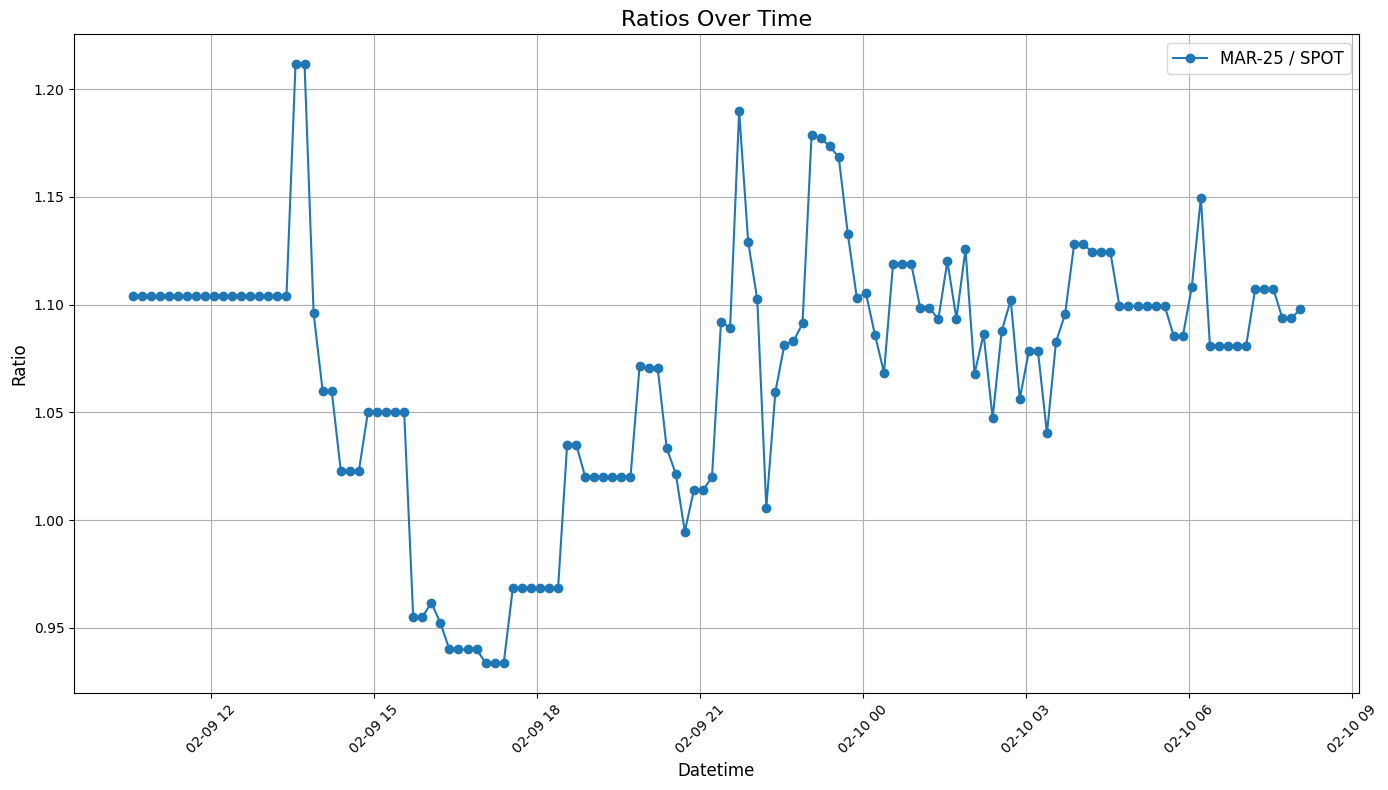

In [23]:
# Convert 'datetime' to pandas datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Calculate ratios
df['Ratio_1'] = (df['MAR-25'] / df['SPOT']) ** (365/days_to_MA)  # (3rd to 2nd) to the power of 12
#df['Ratio_2'] = (df['MAR-25'] / df['SPOT']) ** 3   # (4th to 2nd) to the power of 3
#df['Ratio_3'] = (df['MAR-25'] / df['DEC-24']) ** 4        # (4th to 3rd)


# Plot the ratios
plt.figure(figsize=(14, 8))
plt.plot(df['datetime'], df['Ratio_1'], label='MAR-25 / SPOT', marker='o')
#plt.plot(df['datetime'], df['Ratio_2'], label='MAR-25 / SPOT', marker='s')
#plt.plot(df['datetime'], df['Ratio_3'], label='MAR-25 / DEC-24', marker='^')

# Add labels, title, and legend
plt.title('Ratios Over Time', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Ratio', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Current USD on account

In [24]:
json.loads(cfPrivate.get_accounts())['accounts']['flex']['currencies']['USD']['value']

747.90020080648

# Getting current prices

In [25]:
# # get prices
symbol='PI_XRPUSD'
tickers=json.loads(cfPublic.get_tickers())['tickers'] 
result =[(x['symbol'], x.get('last', None), x.get('bid', None),  x.get('ask', None)) for x in tickers if x['symbol']==symbol]
pd.DataFrame(result)

,0,1,2,3
0,PI_XRPUSD,2.4074,2.4132,2.4148
